## Test de CNN cardIAc

- suit l'article donné en documentation

In [11]:
import tensorflow as tf
import numpy as np
import numpy as np                   # For numerical operations (if needed for data manipulation)
import tensorflow as tf              # To build and train the model
from tensorflow.keras.models import Sequential  # For creating sequential models
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout  # Layers used in the model
from tensorflow.keras.utils import to_categorical  # For one-hot encoding labels (if applicable)
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import serial


In [12]:
path_to_datasets = "../../neural_network/dataset_publications/datas/train_data"

# Training data
train_X_val = np.load(f"{path_to_datasets}/X.npy")

print(train_X_val.shape)

train_X_signal = train_X_val[::,:-2] # remove frequency at the end to get a good looking signal
train_X_freq = train_X_val[::,-2:] # frequency handled separately
print("train_X_signal shape :", train_X_signal.shape)

train_Y_temp = np.load(f"{path_to_datasets}/y_train.npy")
print("train_Y_temp shape :", train_Y_temp.shape)

# Test data
test_X_PCA = np.load(f"{path_to_datasets}/X_test.npy")
test_Y_temp = np.load(f"{path_to_datasets}/y_test.npy")


(5000, 183)
train_X_signal shape : (5000, 181)
train_Y_temp shape : (5000,)


In [13]:
# Vectorize Y for training and test
# Classes :
# - [0] : 'A' (Atrial premature contraction)
# - [1] : 'L' (Left bundle branch block fluctuation)
# - [2] : 'N' (Normal)
# - [3] : 'R' (Right bundle branch block fluctuation)
# - [4] : 'V' (premature ventricular contraction)

def vectorize_Y(arr):
    mapping = {'A': [1, 0, 0, 0, 0],
               'L': [0, 1, 0, 0, 0],
               'N': [0, 0, 1, 0, 0],
               'R': [0, 0, 0, 1, 0],
               'V': [0, 0, 0, 0, 1]}
    
    res = np.array([mapping[val] for val in arr])
    return res

def devectorize_Y(vectorized_arr):
    mapping = {(1, 0, 0, 0, 0): 'A',
               (0, 1, 0, 0, 0): 'L',
               (0, 0, 1, 0, 0): 'N',
               (0, 0, 0, 1, 0): 'R',
               (0, 0, 0, 0, 1): 'V'}
    res = np.array([mapping[tuple(vec)] for vec in vectorized_arr])
    return res

# Vectorize train and test data
train_Y = vectorize_Y(train_Y_temp)
test_Y = vectorize_Y(test_Y_temp)


## Printing dataset samples

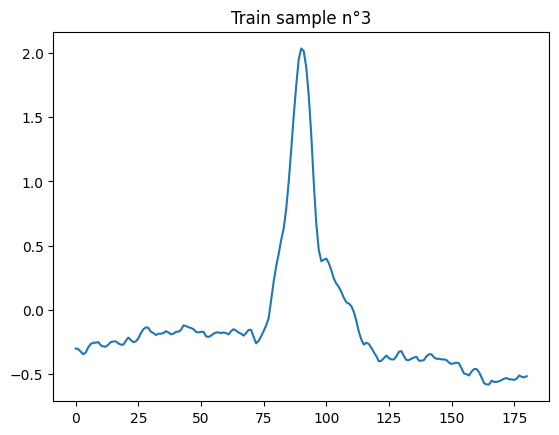

Time diff (prev/next) beat : [242. 246.]


In [14]:
index_shown = 3

plt.plot(np.arange(0, train_X_signal.shape[1]), train_X_signal[index_shown])

plt.title(f"Train sample n°{index_shown}")
plt.show()

print(f"Time diff (prev/next) beat : {train_X_freq[index_shown]}")


In [15]:
# Comptage des différentes classifications

def count_occurrences(arr):
    unique, counts = np.unique(arr, return_counts=True)
    return dict(zip(unique, counts))

count_occurrences(train_Y_temp)

{'A': 971, 'L': 995, 'N': 1038, 'R': 1029, 'V': 967}

# CNN 

In [16]:
# Split train / test

X_train, X_val, Y_train, Y_val = train_test_split(train_X_signal, train_Y, test_size=0.2, random_state=42)

np.save('data/X_train.npy', X_train)
np.save('data/Y_train.npy', Y_train)
np.save('data/X_val.npy', X_val)
np.save('data/Y_val.npy', Y_val)

In [17]:
# CNN Layers
# 2 inputs : signal and time between beats

signal_size = train_X_signal.shape
print("signal size :", signal_size)

# Create the model
model = Sequential()

# Input shape = (256, 1), filters = 4, kernel size = 21
model.add(Conv1D(filters=4, kernel_size=21, activation='relu', input_shape=(181, 1)))

# Pooling size chosen to reach 86, here kernel size = 3 with stride = 3
model.add(MaxPooling1D(pool_size=3, strides=3))

# Filters = 4, kernel size = 21
model.add(Conv1D(filters=4, kernel_size=21, activation='relu'))

# Pooling size chosen to reach 29, here kernel size = 3 with stride = 3
model.add(MaxPooling1D(pool_size=3, strides=3))

# Flatten the output to connect with the fully connected layer
model.add(Flatten())

# Small layers at the output
model.add(Dense(units=32, activation='relu'))

# Input size = 116 (29x4 after Flatten), output size = 5
model.add(Dense(units=5, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model.summary()


signal size : (5000, 181)


c:\Users\Lenovo\Documents\Git_repos\cardIAc\.venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 161, 4)         │            88 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 53, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 33, 4)          │           340 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 11, 4)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 44)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,033 (7.94 KB)

 Trainable params: 2,033 (7.94 KB)

 Non-trainable params: 0 (0.00 B)

(5000, 5)
Epoch 1/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.3627 - loss: 1.4521 - val_accuracy: 0.6950 - val_loss: 0.9426
Epoch 2/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7069 - loss: 0.8538 - val_accuracy: 0.8160 - val_loss: 0.5920
Epoch 3/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8117 - loss: 0.5808 - val_accuracy: 0.8440 - val_loss: 0.4783
Epoch 4/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8264 - loss: 0.4986 - val_accuracy: 0.8600 - val_loss: 0.4309
Epoch 5/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8593 - loss: 0.4083 - val_accuracy: 0.8750 - val_loss: 0.3917
Epoch 6/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8675 - loss: 0.3934 - val_accuracy: 0.8870 - val_loss: 0.3528
Epoch 7/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8766 - loss: 0.3443 - val_accuracy: 0.8840 - val_loss: 0.3521
Epoch 8/32
80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8626 - loss: 0.3618 - val_accuracy: 0.8920 -

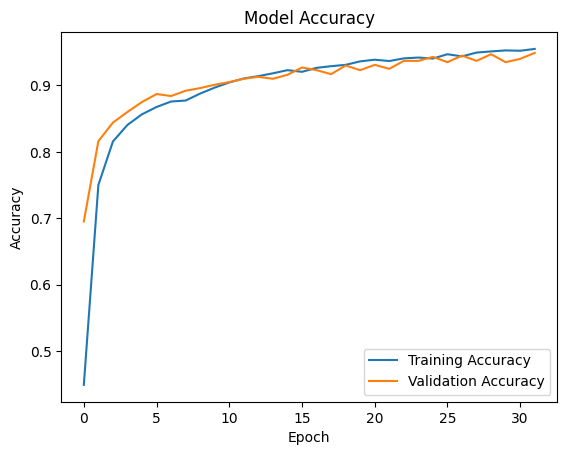

In [18]:
# Compile and train the model

print(train_Y.shape)

optimizer = Adam(learning_rate=0.0015)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train, 
    Y_train, 
    epochs=32, 
    batch_size=50, 
    validation_data=(X_val, Y_val)  # Use validation_data instead of validation_split
)

# Plot the accuracy over epochs
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [19]:
model.save("models/CNN_cardIAc.keras")

model = tf.keras.models.load_model('models/CNN_cardIAc.keras')
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("models/CNN_cardIAc.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Lenovo\AppData\Local\Temp\tmp8bkbttdv\assets


INFO:tensorflow:Assets written to: C:\Users\Lenovo\AppData\Local\Temp\tmp8bkbttdv\assets


Saved artifact at 'C:\Users\Lenovo\AppData\Local\Temp\tmp8bkbttdv'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 181, 1), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2810498770576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2810498762704: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2810498765776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2810498765008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2810498766928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2810498769040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2810498763280: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2810498767696: TensorSpec(shape=(), dtype=tf.resource, name=None)


13524